In [1]:
import os
import numpy as np
import pandas as pd
from datetime import date

import matplotlib.pyplot as plt
import multiprocessing as mp

In [2]:
def update_stocks():
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip ms*.zip -d data/")
    print(f'Updated {date.today()}')

In [3]:
update_stocks()

Updated 2020-03-23


In [4]:
all_files = os.listdir('data/')

In [5]:
len(all_files)

2052

In [28]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

In [7]:
watch = ['PZU', 'KGHM', 'ASSECOSEE', 
         'NORTCOAST', 'CDPROJEKT', 'VOTUM', 
         'NEWAG', 'KRUSZWICA', 'INTERAOLT', 
         'PLAY', 'ARCHICOM', 'LPP', 'ARCTIC', 'PGNIG',
        'TAURONPE', 'PKOBP', 'JSW']

In [8]:
watch_af = ['KGHM','KRUK', 'PKNORLEN','ENEA','MBANK', 'PKOBP', 'WIELTON']

In [25]:
[a for a in all_files if 'PROJ' in a]

['CDPROJEKT.mst', 'PROJPRZEM.mst']

In [67]:
papier = 'KRUSZWICA'

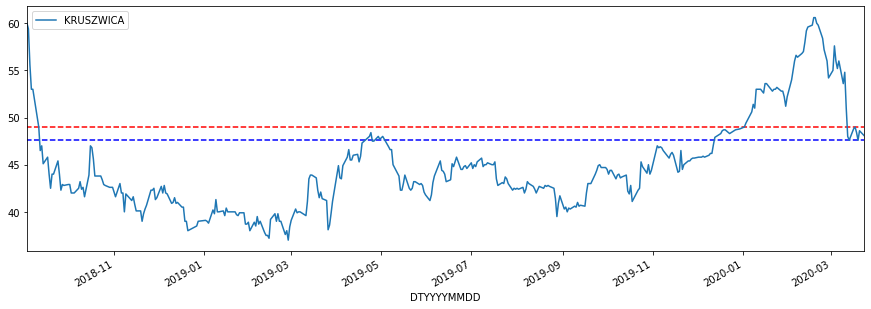

In [72]:
df = pd.read_csv(f'data/{papier}.mst')

df.columns = [str(c).replace('<','') for c in df.columns]
df.columns = [str(c).replace('>','') for c in df.columns]

df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

df = df.set_index('DTYYYYMMDD')

df.loc[df.index > '2018-09-01',['CLOSE']].plot(figsize=(15,5))
plt.hlines(df.loc[df.index >= big_drop_date,'CLOSE'].min(), 
           '2005-12-28', '2020-12-28', 
           linestyles='--', 
           colors='blue')
plt.hlines(df.loc[df.index >= big_drop_date,'CLOSE'].max(), 
           '2005-12-28', '2020-12-28', 
           linestyles='--', 
           colors='red')
plt.legend([df.TICKER[0]])

In [65]:
max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()

crises_min = df.loc[(df.index <= big_drop_date) & 
       (df.index >= before_crises),"CLOSE"].min()

In [66]:
print(papier)
print(f'Gained since big drop: {round((max_after_drop * 1 / crises_min -1)*100, 2)}%')

CCC
Gained since big drop: 0.0%


In [41]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'

df_cols = ['ticker', 'current', 'before_crisis', 'last_y_q',
           'crisis_bottom', 
           'max_after_crisis', 'max_before_crisis']

In [73]:
dfres = pd.DataFrame(columns=df_cols)
for w in watch_af:
    df = pd.read_csv(f'data/{w}.mst')

    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
   
    dfres = pd.concat([dfres,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

In [74]:
dfres.loc[:,'growth_quarter'] = round(dfres.loc[:,'before_crisis'] * 100 / dfres.loc[:,'last_y_q'] - 100, 2)
dfres.loc[:,'growth_from_crisis'] = round(dfres.loc[:,'max_after_crisis'] * 100 / dfres.loc[:,'crisis_bottom'] - 100, 2)
dfres.loc[:,'growth_current'] = round(dfres.loc[:,'current'] * 100 / dfres.loc[:,'crisis_bottom'] - 100, 2)
dfres.loc[:,'drop_current'] = round(dfres.loc[:,'current'] * 100 / dfres.loc[:,'max_before_crisis'] - 100, 2)

In [75]:
dfres.sort_values('growth_quarter', ascending=False)

,ticker,current,before_crisis,last_y_q,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_from_crisis,growth_current,drop_current
0,KGHM,54.64,95.560,77.24,49.40,57.92,101.00,23.72,17.25,10.61,-45.90
0,MBANK,224.00,374.000,345.00,192.10,248.40,400.00,8.41,29.31,16.61,-44.00
0,KRUK,66.00,160.800,151.70,64.00,85.00,175.00,6.00,32.81,3.12,-62.29
0,WIELTON,3.04,7.890,7.65,2.65,3.45,8.14,3.14,30.19,14.72,-62.65
0,PKOBP,21.45,35.550,38.85,21.00,23.50,39.87,-8.49,11.90,2.14,-46.20
0,ENEA,4.80,7.025,8.56,3.87,5.01,9.55,-17.93,29.46,24.03,-49.74
0,PKNORLEN,49.72,75.800,98.56,43.44,52.58,109.05,-23.09,21.04,14.46,-54.41


In [46]:
2.65*0.3 + 2.65

3.445

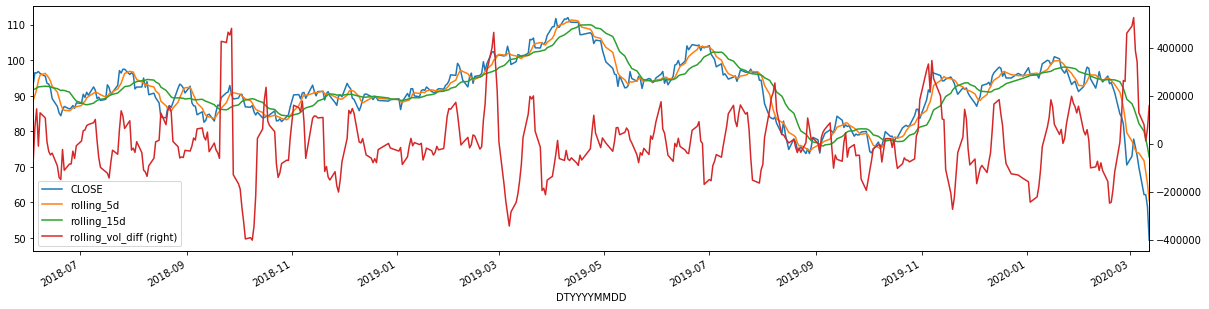

In [19]:
df = pd.read_csv('data/KGHM.mst')

df.columns = [str(c).replace('<','') for c in df.columns]
df.columns = [str(c).replace('>','') for c in df.columns]

df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

df = df.set_index('DTYYYYMMDD')

#df.loc[:,df.columns[1:]] = (df.loc[:,df.columns[1:]] - df.loc[:,df.columns[1:]].mean()) / df.loc[:,df.columns[1:]].std()

df.loc[:,'rolling_5d'] = df.loc[:,'CLOSE'].rolling(5).mean()
df.loc[:,'rolling_15d'] = df.loc[:,'CLOSE'].rolling(15).mean()

df.loc[:,'rolling_vol_5d'] = df.loc[:,'VOL'].rolling(5).mean()
df.loc[:,'rolling_vol_15d'] = df.loc[:,'VOL'].rolling(15).mean()

df.loc[:,'rolling_vol_diff'] = df.loc[:,'rolling_vol_5d'] - df.loc[:,'rolling_vol_15d']

plot_cols = ['CLOSE', 
             'rolling_5d',
             'rolling_15d',
             'rolling_vol_diff']

df.loc[df.index > '2018-06-01',plot_cols].plot(figsize=(20,5), secondary_y = 'rolling_vol_diff')
# plt.hlines(df.loc[df.index > '2020-02-15','CLOSE'].min(), 
#            '2005-12-28', '2020-12-28', 
#            linestyles='--', 
#            colors='blue')
# plt.hlines(df.loc[df.index > '2019-08-15','CLOSE'].min(), 
#            '2005-12-28', '2020-12-28', 
#            linestyles='--', 
#            colors='red')
#plt.legend([df.TICKER[0]] + plot_cols[1:])

In [12]:
df.loc[df.index > '2019-08-15','CLOSE'].min()

5550.0

### Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
